In [2]:
%pip install pandas numpy matplotlib arch statsmodels

  Using cached pandas-3.0.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (79 kB)
  Using cached numpy-2.4.1-cp313-cp313-macosx_14_0_arm64.whl.metadata (6.6 kB)
  Using cached matplotlib-3.10.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (52 kB)
  Using cached arch-8.0.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (13 kB)
  Using cached statsmodels-0.14.6-cp313-cp313-macosx_11_0_arm64.whl.metadata (9.5 kB)
  Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp313-cp313-macosx_10_13_universal2.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pillow-12.1.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.8 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
  Using cached scipy-1.17.0-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached patsy-1.0.2-py2.py3-none-any.whl.

In [3]:
# ============================================================
# 0) Imports (packages we need)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
# The four packages above are pre-installed in anaconda
# So we only need to import them
from arch import arch_model
# This package needs to be installed,  
# for windows type 'conda install -c conda-forge arch-py' without the ' ' in the anaconda prompt (run as admin)


## Data
Data is from Capital IQ, last 12 years of daily prices for Apple and SP500.
Open and close prices are split but not dividend adjusted, ADJCLose is both split and dividend adjusted.



In [7]:
file_path = "modFinRet-1.csv"   # Name of datafile
df = pd.read_csv(file_path) # Reads data into a panda dataframe
df.head(5)
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 3017 entries, 0 to 3016
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           3017 non-null   str    
 1   AAPL Close     3017 non-null   float64
 2   AAPLOpen       3017 non-null   float64
 3   AAPL ADJClose  3017 non-null   float64
 4   SPClose        3017 non-null   float64
dtypes: float64(4), str(1)
memory usage: 118.0 KB


In [8]:
# Looks ok but does not understand that dates are dates
df["Date"] = pd.to_datetime(df["Date"])
df.info()
# We also need to tell pandas to use Date as the index
df = df.set_index("Date")

<class 'pandas.DataFrame'>
RangeIndex: 3017 entries, 0 to 3016
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           3017 non-null   datetime64[us]
 1   AAPL Close     3017 non-null   float64       
 2   AAPLOpen       3017 non-null   float64       
 3   AAPL ADJClose  3017 non-null   float64       
 4   SPClose        3017 non-null   float64       
dtypes: datetime64[us](1), float64(4)
memory usage: 118.0 KB


In [9]:
#compute returns and store them in the same DataFrame
# AAPL: intraday log return (Open -> Close)
df["AAPL_log_ret_oc"] = np.log(df["AAPL Close"]) - np.log(df["AAPLOpen"])

# AAPL: close-to-close log return (price return, excludes dividends)
df["AAPL_log_ret_cc_price"] = np.log(df["AAPL Close"]) - np.log(df["AAPL Close"].shift(1))

# AAPL: close-to-close log return using Adj Close (total return)
df["AAPL_log_ret_cc_total"] = np.log(df["AAPL ADJClose"]) - np.log(df["AAPL ADJClose"].shift(1))

# SP500: close-to-close log return
df["SP_log_ret_cc"] = np.log(df["SPClose"]) - np.log(df["SPClose"].shift(1))

df[[
    "AAPL_log_ret_oc",
    "AAPL_log_ret_cc_price",
    "AAPL_log_ret_cc_total",
    "SP_log_ret_cc"
]].head(10)


,AAPL_log_ret_oc,AAPL_log_ret_cc_price,AAPL_log_ret_cc_total,SP_log_ret_cc
Date,,,,
2014-01-21,0.014825,NaN,NaN,NaN
2014-01-22,0.001079,0.004434,0.004434,0.000570
2014-01-23,0.011283,0.008432,0.008432,-0.008925
2014-01-24,-0.014417,-0.018345,-0.018344,-0.021101
2014-01-27,0.000781,0.008080,0.008080,-0.004886
2014-01-28,-0.004452,-0.083302,-0.083303,0.006120
2014-01-29,-0.006370,-0.011418,-0.011417,-0.010258
2014-01-30,-0.005503,-0.001935,-0.001935,0.011203
2014-01-31,0.010886,0.001635,0.001635,-0.006488


Compunding with log return according to $$W_t=\exp\!\left(\sum_{s \le t} r_s\right),$$ will give value of 1 USD after t periods


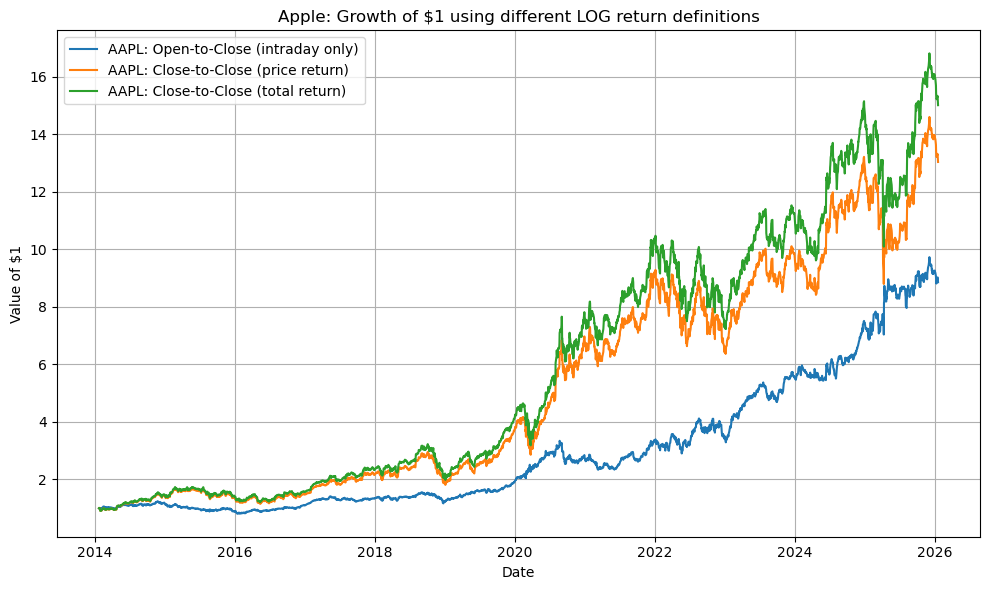

In [6]:
# ============================================================
# Growth of $1 invested in AAPL using LOG returns
# ============================================================

# Dropping missing values if any present
tmp = df[["AAPL_log_ret_oc","AAPL_log_ret_cc_price","AAPL_log_ret_cc_total"]].dropna()

wealth_oc = np.exp(tmp["AAPL_log_ret_oc"].cumsum())
wealth_cc_price = np.exp(tmp["AAPL_log_ret_cc_price"].cumsum())
wealth_cc_total = np.exp(tmp["AAPL_log_ret_cc_total"].cumsum())

plt.figure(figsize=(10, 6))
plt.plot(wealth_oc.index, wealth_oc, label="AAPL: Open-to-Close (intraday only)")
plt.plot(wealth_cc_price.index, wealth_cc_price, label="AAPL: Close-to-Close (price return)")
plt.plot(wealth_cc_total.index, wealth_cc_total, label="AAPL: Close-to-Close (total return)")

plt.title("Apple: Growth of $1 using different LOG return definitions")
plt.xlabel("Date")
plt.ylabel("Value of $1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
# ============================================================
# Aggregate DAILY log returns to lower frequencies
# ============================================================

# Apple: total returns
aapl_daily = df["AAPL_log_ret_cc_total"].dropna()

# S&P 500: price returns
sp_daily = df["SP_log_ret_cc"].dropna()

# Weekly (Friday close convention)
aapl_weekly = aapl_daily.resample("W-FRI").sum()
sp_weekly   = sp_daily.resample("W-FRI").sum()

# Monthly
aapl_monthly = aapl_daily.resample("ME").sum()
sp_monthly   = sp_daily.resample("ME").sum()

# Yearly
aapl_yearly = aapl_daily.resample("YE").sum()
sp_yearly   = sp_daily.resample("YE").sum()
# Collect returns
returns = {
    ("AAPL", "Daily"): aapl_daily,
    ("AAPL", "Weekly"): aapl_weekly,
    ("AAPL", "Monthly"): aapl_monthly,
    ("AAPL", "Yearly"): aapl_yearly,
    ("SP500", "Daily"): sp_daily,
    ("SP500", "Weekly"): sp_weekly,
    ("SP500", "Monthly"): sp_monthly,
    ("SP500", "Yearly"): sp_yearly,
}
results = []

for (asset, freq), r in returns.items():
    r = r.dropna()

    mean = r.mean()
    var = r.var()
    skew = stats.skew(r)
    kurt = stats.kurtosis(r, fisher=True)  # excess kurtosis so Normal dist has 0
    jb_stat, jb_pvalue = stats.jarque_bera(r)

    results.append({
        "Asset": asset,
        "Frequency": freq,
        "Mean": mean,
        "Variance": var,
        "Skewness": skew,
        "Excess Kurtosis": kurt,
        "JB statistic": jb_stat,
        "JB p-value": jb_pvalue
    })

moments_df = pd.DataFrame(results)
# ============================================================
# Convert variances to annualized percentage standard deviations
# ============================================================

freq_scaling = {
    "Daily": 252,
    "Weekly": 52,
    "Monthly": 12,
    "Yearly": 1
}

moments_df["Ann. Volatility (%)"] = (
    np.sqrt(moments_df["Variance"])
    * np.sqrt(moments_df["Frequency"].map(freq_scaling))
    * 100
)

# ============================================================
# Annualize MEAN log returns (percent per year)
# ============================================================

moments_df["Ann. Mean Return (%)"] = (
    moments_df["Mean"]
    * moments_df["Frequency"].map(freq_scaling)
    * 100
)


moments_df = moments_df[[
    "Asset",
    "Frequency",
    "Ann. Mean Return (%)",
    "Ann. Volatility (%)",
    "Skewness",
    "Excess Kurtosis",
    "JB statistic",
    "JB p-value"
]]

moments_df.style.format({
    "Ann. Mean Return (%)": "{:.2f}",
    "Ann. Volatility (%)": "{:.2f}",
    "Skewness": "{:.3f}",
    "Excess Kurtosis": "{:.2f}",
    "JB statistic": "{:.1f}",
    "JB p-value": "{:.3g}"
})

moments_df



,Asset,Frequency,Ann. Mean Return (%),Ann. Volatility (%),Skewness,Excess Kurtosis,JB statistic,JB p-value
0,AAPL,Daily,22.629183,28.268140,-0.099831,6.607462,5491.435028,0.000000e+00
1,AAPL,Weekly,22.497211,27.155292,-0.394537,2.267210,150.315139,2.288138e-33
2,AAPL,Monthly,22.413667,26.330857,-0.240344,-0.394706,2.337240,3.107955e-01
3,AAPL,Yearly,20.833216,27.858527,-0.136592,-0.835486,0.418527,8.111813e-01
4,SP500,Daily,11.074899,17.496334,-0.659698,16.281585,33531.738369,0.000000e+00
5,SP500,Weekly,11.010311,16.562614,-0.909641,7.308231,1479.447273,0.000000e+00
6,SP500,Monthly,10.969424,14.460413,-0.566351,0.864396,12.265741,2.170342e-03
7,SP500,Yearly,10.195939,13.715797,-0.986516,0.174318,2.125089,3.455754e-01


Mean and volatility should not depend on sample frequency, that looks about as expected.

Kurtosis behaves exactly as expected when moving from high to low frequnecy. 

Diversification does not reduce kurtosis as much as it reduces variance (but try this also on you own with for example Game Stop). 

Under the classical CLT, skewness should vanish under aggregation.
In financial data, asymmetries caused by leverage effects and common crash risk persist, so skewness converges slowly and irregularly. Note that the reason we cannot reject normality at the yearly frequency, at least for SP500, is due to low power (12 observations).

Also worth menitioning here, high frequendy data is great (gives more information) for estimating all moments higher than the first but are useless for increasing the precision in the mean return, for the mean you would as well with the first and last price as with the whole daily sample.


## GARCH
We start by simulating a GARCH processes with different parameter values to get some feel for the model

Target daily vol: 0.009449
Target daily var (h_bar): 8.92857143e-05
(alpha,beta)=(0.20,0.65)  omega=1.339e-05  sample ann vol≈0.1457


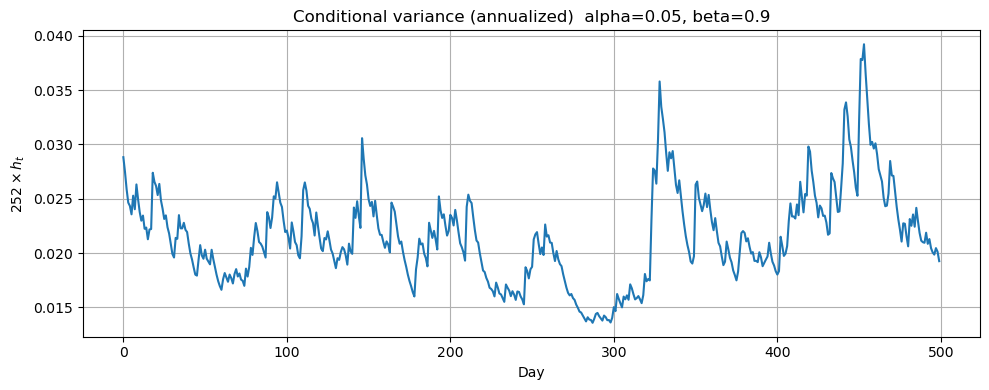

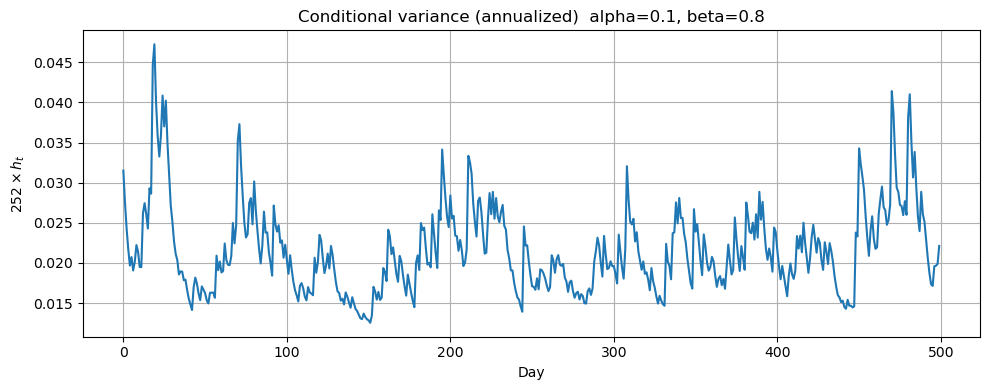

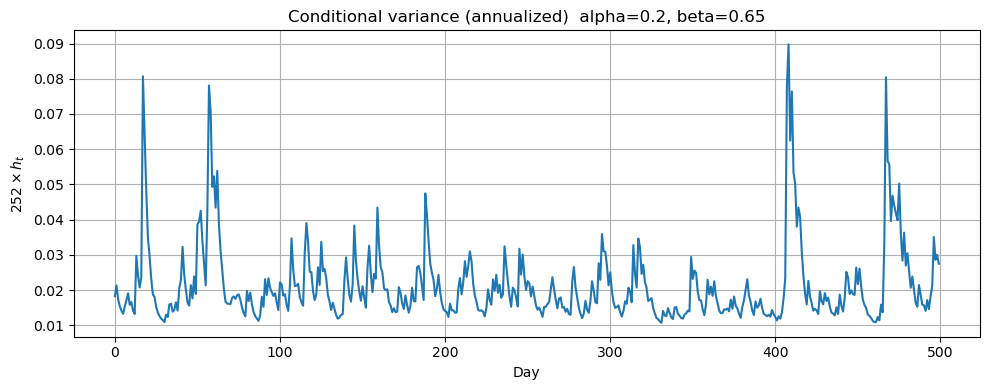

In [19]:
# ------------------------------------------------------------
# Target: unconditional annualized volatility = 15%
# ------------------------------------------------------------
TRADING_DAYS = 252
annual_vol_target = 0.15

daily_vol_target = annual_vol_target / np.sqrt(TRADING_DAYS)
h_bar = daily_vol_target**2  # unconditional DAILY variance

print(f"Target daily vol: {daily_vol_target:.6f}")
print(f"Target daily var (h_bar): {h_bar:.8e}")

def simulate_garch11(T, alpha, beta, h_bar, burn_in=1000, seed=0):
    """
    Simulate a zero-mean Gaussian GARCH(1,1):
        h_t = omega + alpha * eps_{t-1}^2 + beta * h_{t-1}
        eps_t = sqrt(h_t) * z_t,   z_t ~ N(0,1)

    We choose omega so that the unconditional variance is h_bar:
        h_bar = omega / (1 - alpha - beta)
        => omega = h_bar * (1 - alpha - beta)

    burn_in: number of initial observations to discard to reduce dependence on initial conditions.
    """
    if alpha < 0 or beta < 0 or alpha + beta >= 1:
        raise ValueError("Need alpha>=0, beta>=0, and alpha+beta<1 for covariance stationarity.")

    omega = h_bar * (1 - alpha - beta)

    rng = np.random.default_rng(seed)
    z = rng.standard_normal(T + burn_in)

    # Arrays
    h = np.empty(T + burn_in)
    eps = np.empty(T + burn_in)

    # Initialize at unconditional variance
    h[0] = h_bar
    eps[0] = np.sqrt(h[0]) * z[0]

    # Recursion
    for t in range(1, T + burn_in):
        h[t] = omega + alpha * eps[t-1]**2 + beta * h[t-1]
        eps[t] = np.sqrt(h[t]) * z[t]

    # Drop burn-in
    h = h[burn_in:]
    eps = eps[burn_in:]

    return omega, eps, h
# ------------------------------------------------------------
# Parameter sets: (alpha, beta)
# ------------------------------------------------------------
param_sets = [
    (0.05, 0.90),
    (0.10, 0.80),
    (0.20, 0.65),
]

T = 10 * TRADING_DAYS  # 10 years of daily data (2520 obs)

sims = {}

for i, (alpha, beta) in enumerate(param_sets, start=1):
    omega, eps, h = simulate_garch11(T=T, alpha=alpha, beta=beta, h_bar=h_bar, burn_in=2000, seed=123+i)

    df_sim = pd.DataFrame({
        "eps": eps,            # simulated daily return innovations (mean zero)
        "h": h,                # conditional variance
        "sigma": np.sqrt(h),   # conditional std dev
    })

    # Check implied unconditional annualized vol from sample mean of h
    ann_vol_est = np.sqrt(df_sim["h"].mean() * TRADING_DAYS)

    sims[(alpha, beta)] = {
        "omega": omega,
        "data": df_sim,
        "ann_vol_est": ann_vol_est
    }

Nplot = 500  # number of days to display
print(f"(alpha,beta)=({alpha:.2f},{beta:.2f})  omega={omega:.3e}  sample ann vol≈{ann_vol_est:.4f}")
for (alpha, beta), obj in sims.items():
    df_sim = obj["data"].iloc[:Nplot]

    plt.figure(figsize=(10, 4))
    plt.plot(df_sim.index, df_sim["h"] * TRADING_DAYS)
    plt.title(
        f"Conditional variance (annualized)  "
        f"alpha={alpha}, beta={beta}"
    )
    plt.xlabel("Day")
    plt.ylabel(r"$252 \times h_t$")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### GARCH Estimation

In [24]:
# Daily SP500 log returns
sp_ret = df["SP_log_ret_cc"].dropna()

# Rescale to percent (recommended for arch)
sp_ret_pct = 100 * sp_ret

sp_ret_pct.head()


Date
2014-01-22    0.057010
2014-01-23   -0.892479
2014-01-24   -2.110129
2014-01-27   -0.488576
2014-01-28    0.611997
Name: SP_log_ret_cc, dtype: float64

Iteration:      1,   Func. Count:      6,   Neg. LLF: 36434.63688174161
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17438.439998551414
Iteration:      3,   Func. Count:     27,   Neg. LLF: 6156.105014325564
Iteration:      4,   Func. Count:     34,   Neg. LLF: 6924.134393369386
Iteration:      5,   Func. Count:     40,   Neg. LLF: 4251.768915663743
Iteration:      6,   Func. Count:     47,   Neg. LLF: 3827.372809890823
Iteration:      7,   Func. Count:     53,   Neg. LLF: 3826.63305832011
Iteration:      8,   Func. Count:     58,   Neg. LLF: 3826.6303879893685
Iteration:      9,   Func. Count:     63,   Neg. LLF: 3826.630328065685
Iteration:     10,   Func. Count:     68,   Neg. LLF: 3826.630325487171
Iteration:     11,   Func. Count:     72,   Neg. LLF: 3826.6303254871823
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3826.630325487171
            Iterations: 11
            Function evaluations: 72
            Gradient evaluations: 

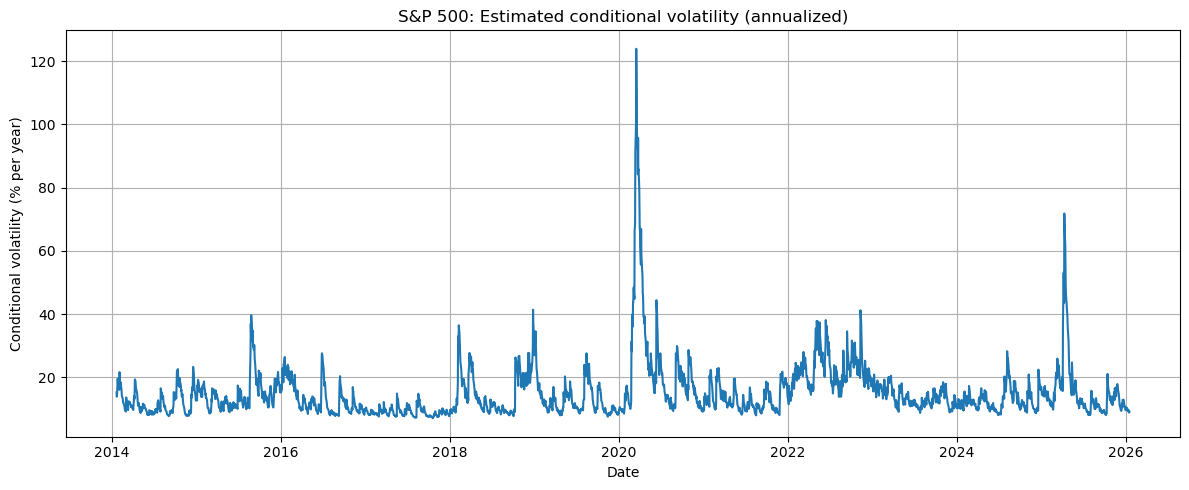

In [29]:
garch = arch_model(sp_ret_pct, vol='garch', p=1, o=0, q=1)
garch_fitted = garch.fit()
print(garch_fitted)
cond_vol = garch_fitted.conditional_volatility
ann_cond_vol = cond_vol * np.sqrt(252)

plt.figure(figsize=(12, 5))
plt.plot(ann_cond_vol.index, ann_cond_vol.values)

plt.title("S&P 500: Estimated conditional volatility (annualized)")
plt.xlabel("Date")
plt.ylabel("Conditional volatility (% per year)")
plt.grid(True)

plt.tight_layout()



## Realized Volatility

In [32]:
# Daily return innovations (levels)
r = df["SP_log_ret_cc"].dropna()

# Daily "realized variance" proxy from daily data (very noisy)
rv_daily = r**2

# GARCH conditional volatility from arch was in percent if you estimated on percent returns.
# If you estimated on percent returns:
cond_vol_pct = garch_fitted.conditional_volatility
cond_var_pct2 = cond_vol_pct**2

# Convert to variance in LEVELS^2: (percent/100)^2
garch_var_daily = (cond_var_pct2 / (100**2))

# Align indices
common_idx = rv_daily.index.intersection(garch_var_daily.index)
rv_daily = rv_daily.loc[common_idx]
garch_var_daily = garch_var_daily.loc[common_idx]


### Aggregate to weekly and monthly using non-overlapping resample sums

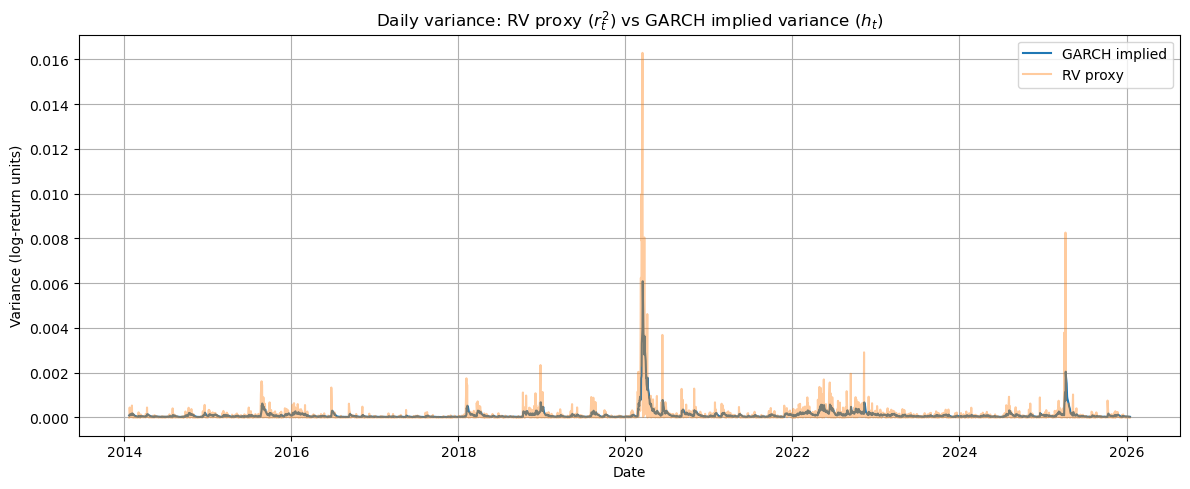

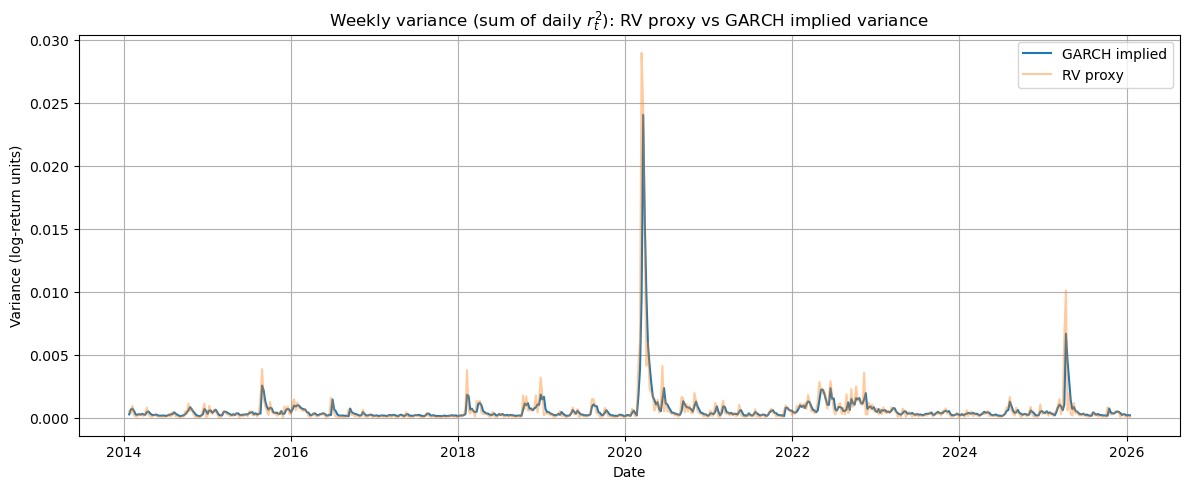

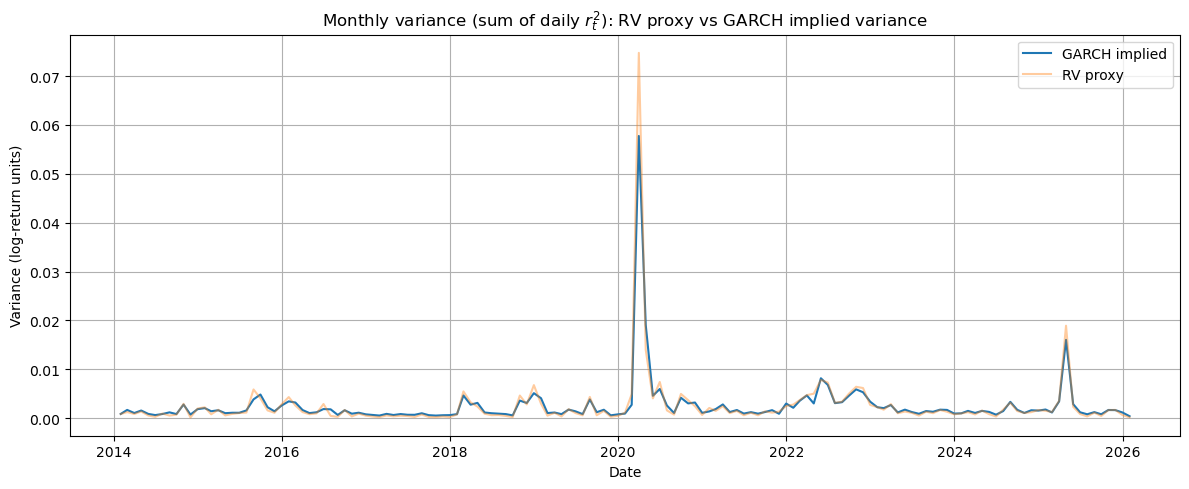

In [41]:
# Weekly (non-overlapping): sum within each week
rv_week = rv_daily.resample("W-FRI").sum()
garch_week = garch_var_daily.resample("W-FRI").sum()

# Monthly (non-overlapping): sum within each month
rv_month = rv_daily.resample("ME").sum()
garch_month = garch_var_daily.resample("ME").sum()

def plot_overlay(rv, garch, title, ylabel="Variance (log-return units)"):
    tmp = pd.DataFrame({"GARCH implied": garch, "RV proxy": rv}).dropna()

    plt.figure(figsize=(12, 5))
    plt.plot(tmp.index, tmp["GARCH implied"], label="GARCH implied")
    plt.plot(tmp.index, tmp["RV proxy"], label="RV proxy",alpha=0.4)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_overlay(
    rv_daily,
    garch_var_daily,
    "Daily variance: RV proxy ($r_t^2$) vs GARCH implied variance ($h_t$)"
)

plot_overlay(
    rv_week,
    garch_week,
    "Weekly variance (sum of daily $r_t^2$): RV proxy vs GARCH implied variance"
)

plot_overlay(
    rv_month,
    garch_month,
    "Monthly variance (sum of daily $r_t^2$): RV proxy vs GARCH implied variance"
)

